# Xenobitmancy, or how to have an encounter with quantum queerness

We learn from the [writings of James Wootten](https://nbviewer.jupyter.org/github/quantumjim/blog/blob/master/Quantum_Procedural_Generation/1_Introduction.ipynb) and his machinations within the quantum realm.

In [1]:
from qiskit import QuantumCircuit, Aer, execute, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_vector
from math import pi
import os, random
import pickle as pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.ndimage

from qiskit.providers.aer.noise import NoiseModel

Link up with the distant machines and feel for their profiles. If you are unable to make this link, read below for the path you must follow.

In [2]:
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_16_melbourne')
coupling_map = backend.configuration().coupling_map

Through the connection, make a copy of their profiles for your own use.

In [3]:
# Generate an Aer noise model for device
noise_model = NoiseModel.from_backend(backend)
basis_gates = noise_model.basis_gates

Arrange the qubits simply, at first, with no logical ordering.

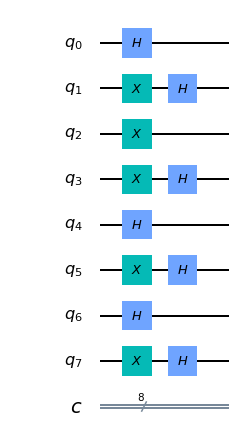

In [4]:
def initialize_qubit_circuit(num = 6):
    qc = QuantumCircuit(num, num)
    
    # Randomly set qubit to be 0 or 1
    for n in range(num):
        if (random.randint(0, 1) == 1):
            qc.x(n)
        
        if (random.randint(0, 1) == 0):
            qc.h(n)
            
    return qc

num = 8
qc = initialize_qubit_circuit(num = num)
qc.draw(output='mpl')

Arrange a means of divining the results.

In [5]:
meas = QuantumCircuit(num, num)
for j in range(num):
    meas.measure(j,j)
#mqc = qc + meas
#mqc.draw(output = 'mpl')

Cast the spell!

In [6]:
backend = Aer.get_backend('qasm_simulator')
shots = 1024

counts_normal = execute(qc + meas,backend,shots=shots).result().get_counts()
counts_noise = execute(qc + meas, backend, shots = shots,
              coupling_map=coupling_map,
              noise_model=noise_model,
              basis_gates=basis_gates).result().get_counts()

Collect the executable words.

In [7]:
# Taken from <https://stackoverflow.com/questions/30399534/shift-elements-in-a-numpy-array>
# use np.roll and np.put by IronManMark20
def shift2(arr, num, default = 0):
    arr=np.roll(arr,num)
    if num<0:
         np.put(arr, range(len(arr)+num,len(arr)), default)
    elif num > 0:
         np.put(arr, range(num), default)
    return arr

def populate_array_counts(counts, shots = 4096, num = 4, offset = 0, log = False):
    a = np.zeros((1, 2**num))    
    #print(a)
    if log:
        a += np.log(1/10)
        #print(a)
    
    for state in counts.keys():
        i = int(state, 2)
        
        if log:
            a[0, i] = np.log(counts[state]/shots)
        else:
            a[0, i] = counts[state]/shots
        
    
    max_a = np.max(np.abs(a))
    #print(max_a)
    a = a/max_a
    
    if (offset != 0):
        a = shift2(a, offset)
    
    return np.abs(a)

def plot_array(array_counts, 
               num = 4, 
               smooth = False, 
               cmap_name = 'gray', 
               save = False, 
               dpi = 300, 
               stem = "xenobitmancy",
                 folder = "graphics"):
    grid_size = int(np.sqrt(2**num))
    b = array_counts.reshape((grid_size, grid_size))
    
    if smooth: b = scipy.ndimage.zoom(b, 6)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(8,8)
    cs = ax.contourf(b, 25,vmin=0,vmax=1,cmap=cm.get_cmap(cmap_name))
    plt.axis('off')
    if save:
        if smooth:
            if folder is not None:
                plt.savefig(os.path.join(folder, "{}_{}_smoothed.png".format(stem, cmap_name)), dpi = dpi)
        else:
            if folder is not None:
                plt.savefig(os.path.join(folder, "{}_{}.png".format(stem, cmap_name)), dpi = dpi)
            else:
                plt.savefig("{}_{}.png".format(stem, cmap_name), dpi = dpi)
    plt.show()

def entangle_qc(qc, steps = 5, rate = pi/16., max_factor = 6):
    num_qbits = qc.num_qubits
    
    for qbit in range(num_qbits):
        if (steps > 2):
            random_steps = random.randint(steps - 2, steps)
        else:
            print("No steps, returning qc unchanged")
            return qc

        for step in range(random_steps):
            axis = random.randint(0, 2)
            
            if (axis == 0):
                qc.rx(random.randint(1, max_factor) * random.choice([-1, 1]) * rate, qc.qregs[0][qbit])
            elif (axis == 1):
                qc.ry(random.randint(1, max_factor) * random.choice([-1, 1]) * rate, qc.qregs[0][qbit])
            elif (axis == 2):
                qc.rz(random.randint(1, max_factor) * random.choice([-1, 1]) * rate, qc.qregs[0][qbit])
                
            # random cnot
            if (random.random() > 0.5):
                random_qbit = random.randint(0, num_qbits - 1)
                while(random_qbit == qbit):
                    random_qbit = random.randint(0, num_qbits - 1)
                
                qc.qregs[0][qbit]
                qc.qregs[0][random_qbit]
                qc.cx(qc.qregs[0][qbit], qc.qregs[0][random_qbit])
                
    return qc

def save_qc(orig_qc, entangled_qc, noise_model, basis_gates, run, stem = "xenobitmancy_8xenobits", qcs_dir = "qcs"):
    qcs = [orig_qc, entangled_qc]
    if qcs_dir is not None:
        with open(os.path.join(qcs_dir, "{}_{:03d}.pickle".format(stem, run)), "wb") as f:
            pickle.dump(qcs, f)
    else:
        with open("{}_{:03d}.pickle".format(stem, run), "wb") as f:
            pickle.dump(qcs, f)

View the simple conjuring.

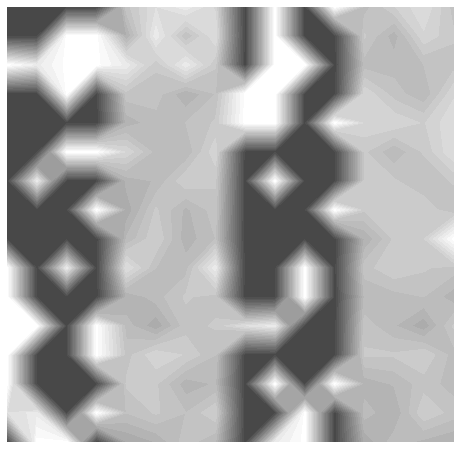

In [8]:
a = populate_array_counts(counts_noise, num = num, log = True)
plot_array(a, num)

Entangle the simple one beyond our comprehension.

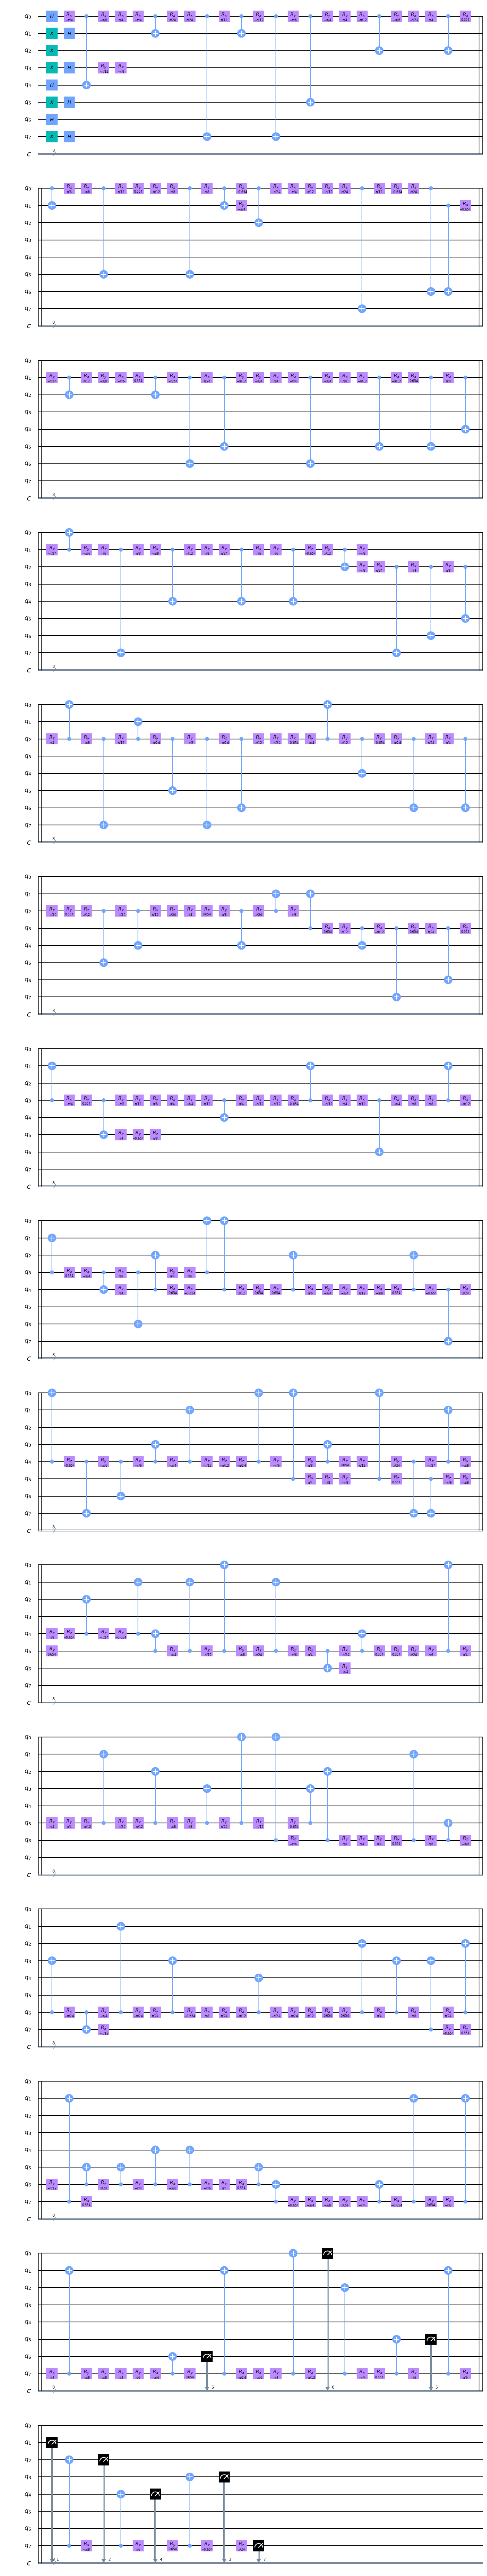

In [9]:
entangled_qc = entangle_qc(qc, steps = 32, rate = pi/24)
(entangled_qc + meas).draw(output='mpl')

Cast this entangled spell!

In [10]:
entangled_counts_normal = execute(entangled_qc + meas,backend,shots=shots).result().get_counts()
entangled_counts_noise = execute(entangled_qc + meas, backend, shots = shots,
              coupling_map=coupling_map,
              noise_model=noise_model,
              basis_gates=basis_gates).result().get_counts()

Ensure that we can refer to this spell again, if it is deemed interesting.

In [11]:
run = 35
#%mkdir -p qcs
save_qc(qc, entangled_qc, noise_model, basis_gates, run, stem = "xenobitmancy_8xenobits")

Prepare things for viewing.

In [12]:
entangled_a_noise = populate_array_counts(entangled_counts_noise, num = num, offset = 9)
entangled_a_normal = populate_array_counts(entangled_counts_normal, num = num, offset = 9)

Examine the nooks and cranies for that which does not want to be felt.

In [13]:
diff = np.abs(entangled_a_noise - entangled_a_normal)
diff_normalized = diff/np.max(diff)

Show us!

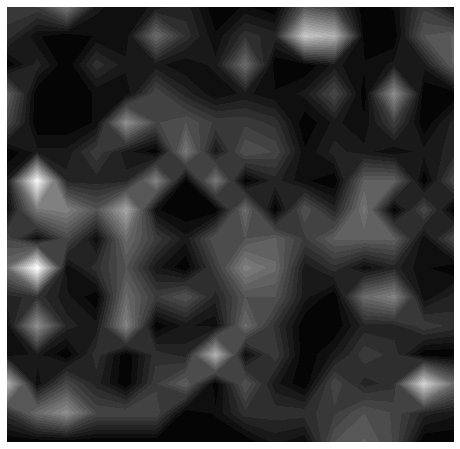

In [14]:
plot_array(entangled_a_normal, num, cmap_name="gray")

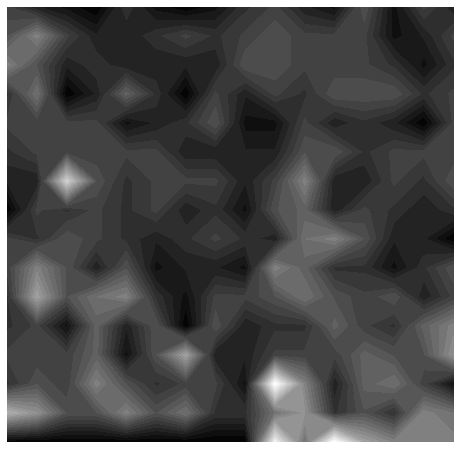

In [15]:
plot_array(entangled_a_noise, num)

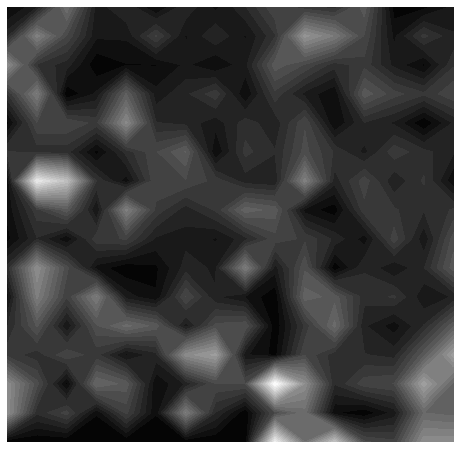

In [16]:
# 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 
# 'cividis', 'cividis_r',
# 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r',
# 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 
# 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 
# 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 
# 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 
# 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 
# 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 
# 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'
#%mkdir -p graphics
plot_array(diff_normalized, num, 
           cmap_name="gray", 
           smooth = False,
           save = True, 
           stem = "xenobitmancy_8xenobits_{:03d}".format(run))

# How to link up with the machine

Take the secret code you received from the algorithm. Save them close to you. *Do this only once*, and only if you feel a need to link with the ones who claim to have all the power.

In [ ]:
from qiskit import IBMQ
IBMQ.save_account('')

# Tallying how the sticks fall

In [ ]:
plot_histogram(counts_normal)

In [ ]:
plot_histogram(counts_noise)

In [ ]:
plot_histogram(entangled_counts_normal)

In [ ]:
plot_histogram(entangled_counts_noise)